![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)

## 1. Librerias

Para empezar carguemos esas librerias que nos hacen falta

In [ ]:
import numpy as np
import time
import datetime
import random
import pandas as pd
import os

from matplotlib import pyplot as plt
from tensorflow import keras as ks
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

## 1.1. Preparamos los datos

Cargamos los datos de CIFAR10 de los datasets directamente de las librerias de Keras. Estos ya estan dispuestos en train and test

**Detalle importante:** 
> La red neuronal requiere que los inputs sean números reales, y lo haremos forzando la division de los valores de dentro de las matrices 28x28 (que tienen valoress del 0 al 255) por 255.0 (un real)

In [ ]:
cifar10 = ks.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train_scaled, x_test_scaled = x_train / 255.0, x_test / 255.0           

In [ ]:
print(y_train)
print(y_test)


[[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]
[[3]
 [8]
 [8]
 ...
 [5]
 [1]
 [7]]


Obtenemos un array con todas las labels de CIFAR10

In [ ]:
cifar10_labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
print('labels: %s' % (cifar10_labels))

labels: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Pintemos una muestra de las imagenes del dataset CIFAR10, a ver si se parece en algo a lo que esperamos.
Primero, vemos que tipos de datos tengo, después mapeamos esas matrices en una escala de grises utilizando el método **.get_cmap()** de PlotLy con los nueve primeros números del dataset.

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


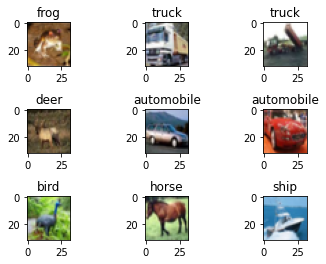

In [ ]:
print('Train: X=%s, y=%s' % (x_train_scaled.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test_scaled.shape, y_test.shape))

for i in range(9):

    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
    plt.title(cifar10_labels[y_train[i,0]])

plt.subplots_adjust(hspace = 1)
plt.show()

Como vamos a querer ir haciendo validación a la vez que entrenamos (muy practico)

In [ ]:
x_val = x_train[-10000:]
x_train = x_train[:-10000]

In [ ]:
x_val_scaled= x_train_scaled[-10000:]
y_val = y_train[-10000:]
x_train_scaled= x_train_scaled[:-10000]
y_train = y_train[:-10000]


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y_train)

y_train_encoded = le.transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
y_train.shape
y_train_reshape = np

In [ ]:
print(y_train_encoded)
print(y_test_encoded)
print(y_val_encoded)

[6 9 9 ... 6 2 8]
[3 8 8 ... 5 1 7]
[1 8 5 ... 9 1 1]


In [ ]:
y_train_encoded

array([6, 9, 9, ..., 6, 2, 8])

Cuando añadimos convoluciones, necesitamos "pre-tratar los datos", porque **la convolución es pera una matriz de 4 campos** (más parecido a "imagenes"), no un array de 3 como son actualmente los data sets de train, test y validación. Así que toca darle al **.reshape()**

Por eso, al salir de la Convolution, hay que hacer un Flatten, porque las capas FullDense esperan arrays, no matrices!!

Luego lo imprimimos para ver que todo está correcto

In [ ]:
print('Train: X=%s, y=%s' % (x_train_scaled.shape, y_train_encoded.shape))
print('Test: X=%s, y=%s' % (x_test_scaled.shape, y_test_encoded.shape))
print('Val: X=%s, y=%s' % (x_val_scaled.shape, y_val_encoded.shape))



Train: X=(40000, 32, 32, 3), y=(40000,)
Test: X=(10000, 32, 32, 3), y=(10000,)
Val: X=(10000, 32, 32, 3), y=(10000,)


# 2. VGG16 Carga de la parte de extraccion de features

Dos aproximaciones distintas...


Basic se hace en dos pasos:
Se cargar VGG16, sin classifcacion hasta el flatten, se procesan las imagenes hasta el bottleneck (donde se estrecha VGG16)
Se monta la red de clasificacion con un input_shape fijado a partir de la salida de VGG16 (su flatten) y se entrena con los datos pasados por VGG16
Fine Tuning, como requiere entrenar una red completa, se carga VGG16, se "descongelan capas" y se empalma con una red de clasificacion.

en FT se entrena TODA la red... en Basic solo la classificacion tras pasar los datos por "preprocesado"

In [ ]:

vgg = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(32,32,3))
vgg.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [ ]:
_
def_output = vgg.layers[-1].output
new_output_layer = ks.layers.Flatten()(def_output)
new_output_layer


<KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'flatten')>

In [ ]:

vgg_model = Model(vgg.input, new_output_layer)
vgg_model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [ ]:
# mirem com estan els pesos de la xarxa vgg16

pd.set_option('max_colwidth', None)                                             
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Trainable?'])


,Layer Type,Layer Name,Trainable?
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fd11ab76a58>,input_1,True
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd0d8941550>,block1_conv1,True
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd0d811e2e8>,block1_conv2,True
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fd0d80c98d0>,block1_pool,True
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd0d80c9c88>,block2_conv1,True
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd0d80d0eb8>,block2_conv2,True
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fd0d80d7f60>,block2_pool,True
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd0d80e60b8>,block3_conv1,True
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd0d80db898>,block3_conv2,True
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd0d80e69b0>,block3_conv3,True


In [ ]:

print(vgg_model.trainable)


True


In [ ]:
# obrim la porta a poderlos modificar despres
vgg_model.trainable = True    
'''
# pero els posem en false de moment
for layer in vgg_model.layers:
  layer.trainable = False
'''

'\n# pero els posem en false de moment\nfor layer in vgg_model.layers:\n  layer.trainable = False\n'

In [ ]:
# comprobem que estiguin en false
pd.set_option('max_colwidth', None)                                             
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Trainable?'])


,Layer Type,Layer Name,Trainable?
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fd11ab76a58>,input_1,True
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd0d8941550>,block1_conv1,True
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd0d811e2e8>,block1_conv2,True
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fd0d80c98d0>,block1_pool,True
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd0d80c9c88>,block2_conv1,True
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd0d80d0eb8>,block2_conv2,True
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fd0d80d7f60>,block2_pool,True
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd0d80e60b8>,block3_conv1,True
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd0d80db898>,block3_conv2,True
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd0d80e69b0>,block3_conv3,True


In [ ]:
'''
trainable = False

for layer in vgg_model.layers:
  if layer.name in ['input_1']:
    trainable = True
  if trainable:
    layer.trainable = True
  else:
    layer.trainable = False
'''

"\ntrainable = False\n\nfor layer in vgg_model.layers:\n  if layer.name in ['input_1']:\n    trainable = True\n  if trainable:\n    layer.trainable = True\n  else:\n    layer.trainable = False\n"

In [ ]:
# comprobem que estiguin en false
pd.set_option('max_colwidth', None)                                             
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Trainable?'])

,Layer Type,Layer Name,Trainable?
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fd11ab76a58>,input_1,True
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd0d8941550>,block1_conv1,True
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd0d811e2e8>,block1_conv2,True
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fd0d80c98d0>,block1_pool,True
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd0d80c9c88>,block2_conv1,True
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd0d80d0eb8>,block2_conv2,True
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fd0d80d7f60>,block2_pool,True
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd0d80e60b8>,block3_conv1,True
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd0d80db898>,block3_conv2,True
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd0d80e69b0>,block3_conv3,True


In [ ]:

# MONTAMOS RED DE CLASIFICACION

input_shape = vgg_model.output_shape[1]
print(input_shape)


512


In [ ]:

# ARQUITECTURA CON  VGG16

model_ft_vgg = ks.Sequential()

model_ft_vgg.add(vgg_model)
model_ft_vgg.add(ks.layers.Dense(256, activation='relu', input_shape=(input_shape,)))
model_ft_vgg.add(ks.layers.Dropout(0.6))  

model_ft_vgg.add(ks.layers.Dense(256, activation='relu', input_shape=(input_shape,)))
model_ft_vgg.add(ks.layers.Dropout(0.6))

model_ft_vgg.add(ks.layers.Dense(10, activation='softmax'))
model_ft_vgg.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 14,914,378
Trainable params: 14,914,378
Non-trainable params: 0
____________________________________________

Para revisar un modelo, nos basta con llamar al método **.summary()** del modelo

## 3. Optimizador, función error


In [ ]:
# OPTIMIZADOR DEL VGG
new_adam = Adam(learning_rate=0.000005)
model_ft_vgg.compile(optimizer=new_adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])



# 3.1 Early stopping mediante callbacks


In [ ]:
callback_val_loss = EarlyStopping(monitor="val_loss", patience=15)
callback_val_accy = EarlyStopping(monitor="val_accuracy", patience=20)


# 4. Data Augmentation

In [ ]:

train_datagen = ImageDataGenerator( 
    rescale=1./255,
    horizontal_flip=True,
    # rotation_range = 10,
    # shear_range = 0.1,
    # zoom_range= 0.1,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # brightness_range=(0.8,1.2),
    # fill_mode='nearest'
    )

train_generator = train_datagen.flow( 
    x_train, 
    y_train_encoded, 
    batch_size=32         
    )


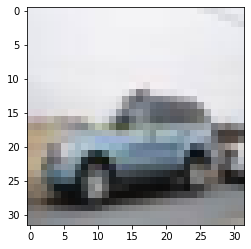

In [ ]:

sample = random.choice(range(0,1450))
example_generator = train_datagen.flow(
    x_train[sample:sample+1],
    y_train[sample:sample+1],
    batch_size=32
    )

plt.imshow(x_train[sample])


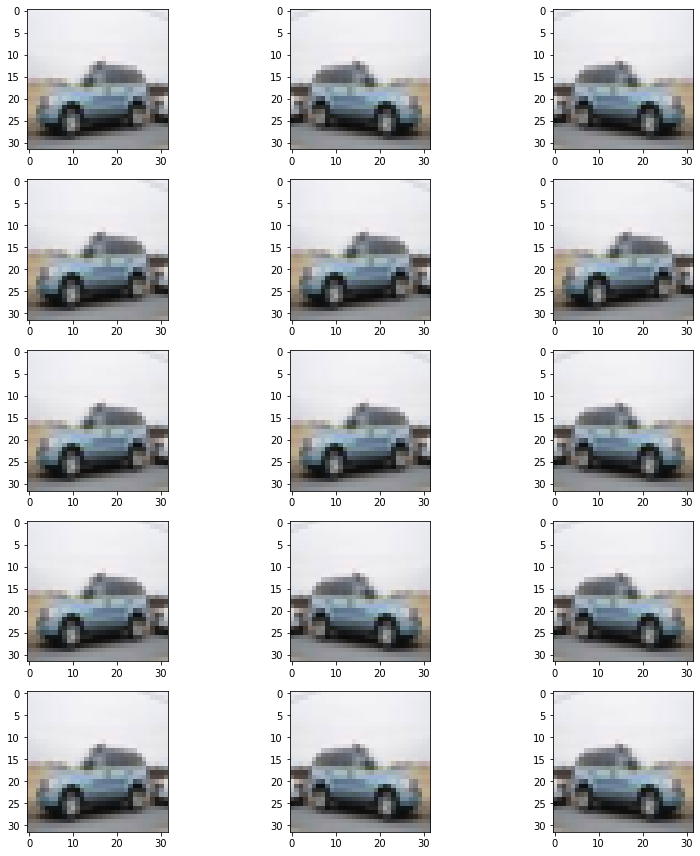

In [ ]:

plt.figure(figsize=(12,12))
for i in range(0,15):
    plt.subplot(5,3,i+1)
    for X, Y in example_generator:
        image = X[0]
        plt.imshow(image)
        break

plt.tight_layout()
plt.show()


In [ ]:

validation_datagen = ImageDataGenerator(
    rescale=1./255
    )
validation_generator = validation_datagen.flow(
    x_val, 
    y_val_encoded, 
    batch_size=32
    )

test_datagen = ImageDataGenerator(
    rescale=1./255
    )
test_generator = test_datagen.flow(
    x_test, 
    y_test_encoded,
    batch_size=32
    )


## 5. Entrenamiento

Ya podemos ponernos a entrenar el modelo!! Ojo, que hemos de entrenar contra los datos convertidos al formato que espera la Convolution.

Empezaremos con 30 epocs, es decir, 30 pasadas completas del dataset (que a su vez sera con mini-batches internamente), fijando un batch de 64

El metodo .fit() nos permite, definir además si disponemos de varias CPUs, GPUs, y si queremos ir validando datos a cada fin de epoch.

In [ ]:
t = time.perf_counter()

In [ ]:
# VGG16 + DA
history = model_ft_vgg.fit(train_generator, epochs=200, steps_per_epoch=512, callbacks=[callback_val_loss,callback_val_accy], validation_data=validation_generator, validation_steps=128)


# VGG16
# history = model_ft_vgg.fit(x_train_scaled, y_train_encoded, epochs=100, callbacks=[callback_val_loss,callback_val_accy], batch_size= 128, validation_data=(x_val_scaled, y_val_encoded))


Epoch 1/200
78/78 [==============================] - 21s 203ms/step - loss: 2.3898 - accuracy: 0.1268 - val_loss: 1.8049 - val_accuracy: 0.4608
Epoch 2/200
78/78 [==============================] - 14s 185ms/step - loss: 1.7580 - accuracy: 0.3824 - val_loss: 1.1492 - val_accuracy: 0.6115
Epoch 3/200
78/78 [==============================] - 14s 181ms/step - loss: 1.2695 - accuracy: 0.5613 - val_loss: 0.9834 - val_accuracy: 0.6673
Epoch 4/200
78/78 [==============================] - 14s 179ms/step - loss: 1.0924 - accuracy: 0.6215 - val_loss: 0.8859 - val_accuracy: 0.6967
Epoch 5/200
78/78 [==============================] - 14s 178ms/step - loss: 0.9931 - accuracy: 0.6600 - val_loss: 0.8281 - val_accuracy: 0.7194
Epoch 6/200
78/78 [==============================] - 14s 180ms/step - loss: 0.9312 - accuracy: 0.6841 - val_loss: 0.7939 - val_accuracy: 0.7285
Epoch 7/200
78/78 [==============================] - 14s 181ms/step - loss: 0.8821 - accuracy: 0.6996 - val_loss: 0.7603 - val_accuracy:

## 6. Evaluamos el Modelo

In [ ]:
# VGG16
_, acc = model_ft_vgg.evaluate(x_test_scaled, y_test_encoded, verbose=0)
print('Accuracy:',' %.3f' % (acc))


Accuracy:  0.839


In [ ]:
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

print('Tiempo de entrenamiento:', elapsed_time)

Tiempo de entrenamiento: 0:17:18.868533


In [ ]:
# for VGG16
_, acc = model_ft_vgg.evaluate(x_test_scaled, y_test_encoded, verbose=0)
print('Accuracy:',' %.3f' % (acc))

Accuracy:  0.839


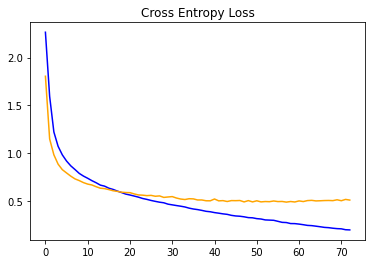

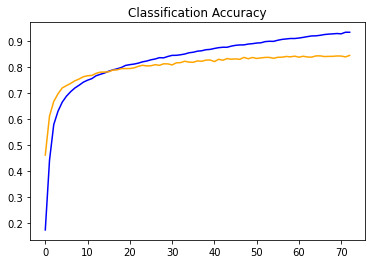

In [ ]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test')
plt.show()

El coste podemos ver que es estable y es en el epoch 15 que se fija en un valor. Además la accuracy baila alrededor de 0.10. No se puede decir que sea un modelo muy bueno.

Veamos que tipo de predicciones estoy obteniendo sobre el conjunto de test (vamos a pintar las imagenes y sus clasificaciones)

In [ ]:
predictions = model_ft_vgg.predict(x_test_scaled)

Una de las ventajas de Python es que hay montones de funciones y código realizado por terceras personas. Aquí me he fusilado unas bonitas funciones (que he adaptado un poco a mis necesidades) para poder pintar las imagenes, su label (ground truth) y las clasificaciones que hemos realizado.

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label[0]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label[0]].set_color('blue')

Dibujamos las primeras imagenes, con las predicciones y sus valores reales (un total de 20 imagenes, para no abusar de vuestros laptops)

Coloreamos las prediciones correctas en azul y los fallos en rojo. Aunque primero he impreso las etiquetas para que tengamos una referencia al grafico.

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


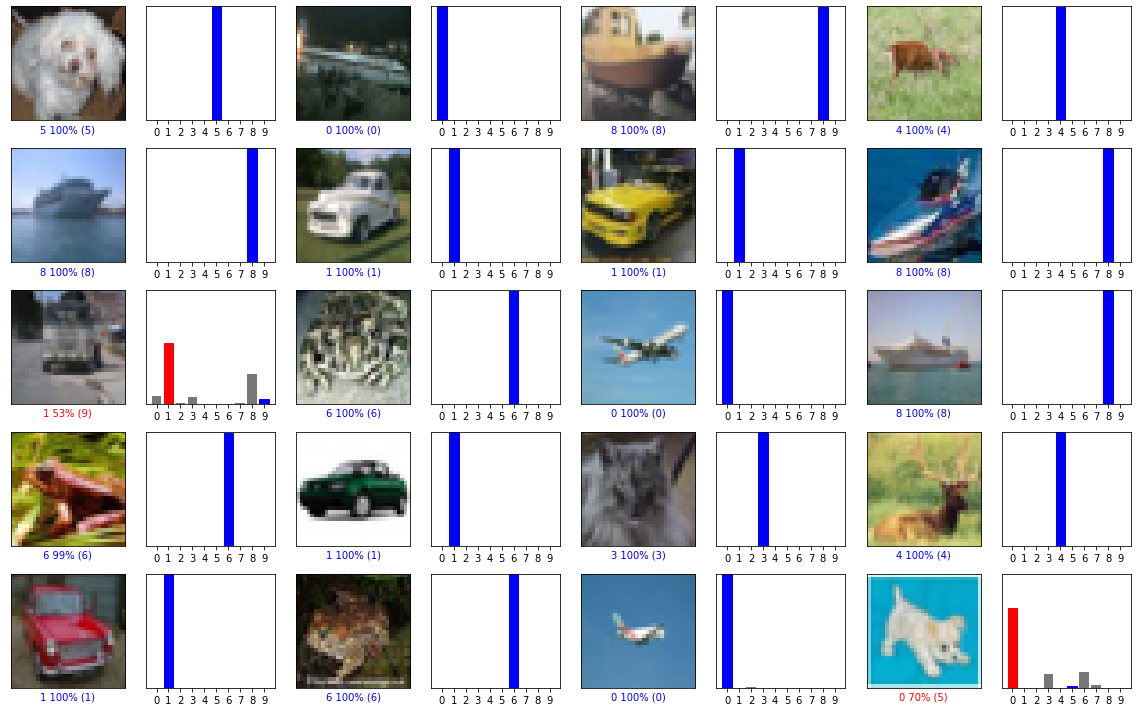

In [ ]:

i = 0
for l in cifar10_labels:
    print(i, l)
    i += 1

num_rows = 5
num_cols = 4
start = 1000
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i+start, predictions[i+start], y_test, x_test_scaled)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i+start, predictions[i+start], y_test)
plt.tight_layout()
plt.show()